In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# 里程计运动模型

技术上说，里程计信息就是传感器测量，而不是控制。为了建立作为测量的里程计模型，产生的贝叶斯滤波必须包括作为状态变量的实际速度——这会增加状态空间的维度。为了保持状态空间比较小，通常把里程计数据认为是控制信号。

里程计模型使用相对运动信息（Relative Motion Information），该信息由机器人内部里程计测量。在时间间隔$(t-1, t]$内，机器人从位姿$x_{t-1}$前进到位姿$x_t$。里程计反馈了$\bar x_{t-1} = (\bar x \, \bar y \, \bar \theta)^T$到$\bar x_t = (\bar x' \, \bar y' \, \bar \theta')^T$的相对前进。这里的$-$代表其是嵌在机器人内部坐标的，该坐标系与全局世界坐标的关系是未知的。

在状态估计中，利用这个信息的关键就是$\bar x_{t-1}$和$\bar x_t$之间的相对差，是真实位姿$x_{t-1}$和$x_t$之间差异的一个很好的估计器。因此，运动信息$u_t$由下式给定：
$$u_t = \begin{bmatrix} \bar x_{t-1} \\ \bar x_t \end{bmatrix}$$

为了提取相对距离，$u_t$被转变为三个步骤的序列：旋转、直线运动（平移）和另一个旋转。如下图所示，可以分解为：初始旋转$\delta_{rot1}$、平移$\delta_{trans}$和第二次旋转$\delta_{rot2}$。每对位置$(\bar s \, \bar s')$都具有唯一的参数向量$(\delta_{rot1} \, \delta_{trans} \, \delta_{rot2})^T$，这些参数足以重现$\bar s$和$\bar s'$之间的相对运动。

![](./img/odometry.jpg)

## 1. 里程计运动模型的数学推导

### 1.1 根据$u_t$计算参数向量

任意两个位姿之间的相对差可以由三个串联的基本运动表示：旋转、直线运动（平移）和另一个旋转。若里程计的读数为$u_t = (\bar x_{t-1} \, \bar x_t)^T$，其中$x_{t-1} = (\bar x \, \bar y \, \bar \theta)^T$，$x_t = (\bar x' \, \bar y' \, \bar \theta')^T$，可以通过以下方程计算两个旋转值和一个平移值：

$$\begin{align}
\delta_{rot1} &= arctan2(\bar y' - \bar y, \bar x' - \bar x) - \bar \theta \\
\delta_{trans} &= \sqrt{(\bar x - \bar x')^2 + (\bar y - \bar y')^2} \\
\delta_{rot2} &= \bar \theta' - \bar \theta - \delta_{rot1}
\end{align}$$

### 1.2 运动误差的模型

为了建立运动误差的模型，假定旋转和平移的“真”值是用测量值减去均值为$0$、方差为$\sigma^2$的独立噪声$\varepsilon_{\sigma^2}$获得：

$$\begin{align}
\widehat \delta_{rot1} &= \delta_{rot1} - \varepsilon_{\alpha_1 \delta_{rot1}^2 + \alpha_2 \delta_{trans}^2} \\
\widehat \delta_{trans} &= \delta_{trans} - \varepsilon_{\alpha_3 \delta_{trans}^2 + \alpha_4 \delta_{rot1}^2 + \alpha_4 \delta_{rot2}^2} \\
\widehat \delta_{rot2} &= \delta_{rot2} - \varepsilon_{\alpha_1 \delta_{rot2}^2 + \alpha_2 \delta_{trans}^2} \\
\end{align}$$

其中$\alpha_1 \sim \alpha_4$是针对机器人的误差参数。

### 1.3 计算实际位置

实际位置$x_t$，从$x_{t-1}$经过初始旋转角$\widehat \delta_{rot1}$，跟随平移距离$\widehat \delta_{trans}$，再跟随另一个旋转角$\widehat \delta_{rot2}$得到，因此有：

$$\begin{bmatrix}x' \\ y' \\ \theta' \end{bmatrix} =
\begin{bmatrix} x \\ y \\ \theta \end{bmatrix} +
\begin{bmatrix}
\widehat \delta_{trans} cos(\theta + \widehat \delta_{rot1}) \\
\widehat \delta_{trans} sin(\theta + \widehat \delta_{rot1}) \\
\widehat \delta_{rot1} + \widehat \delta_{rot2}
\end{bmatrix}
$$

### 1.4 计算$p(x_t \, | \, u_t , x_{t-1})$

相对于初始位姿$x_{t-1}$，计算假想的位姿$x_t$的运动参数$\widehat \delta_{rot1}$，$\widehat \delta_{trans}$和$\widehat \delta_{rot2}$，两者的差别如下：

$$\begin{align}
\delta_{rot1} - \widehat \delta_{rot1} \\
\delta_{trans} - \widehat \delta_{trans} \\
\delta_{rot2} - \widehat \delta_{rot2} \\
\end{align}$$

这就是里程计误差，误差模型意味着这些误差的概率可由上面定义的分布$\varepsilon$给定：

$$\begin{align}
p_1 &= \varepsilon_{\alpha_1 \delta_{rot1}^2 + \alpha_2 \delta_{trans}^2}(\delta_{rot1} - \widehat \delta_{rot1}) \\
p_2 &= \varepsilon_{\alpha_3 \delta_{trans}^2 + \alpha_4 \delta_{rot1}^2 + \alpha_4 \delta_{rot2}^2}(\delta_{trans} - \widehat \delta_{trans}) \\
p_3 &= \varepsilon_{\alpha_1 \delta_{rot2}^2 + \alpha_2 \delta_{trans}^2}(\delta_{rot2} - \widehat \delta_{rot2}) \\
\end{align}$$

联合误差概率为：$p_1 \cdot p_2 \cdot p_3$。

## 2. 里程计运动模型采样算法

In [2]:
def sample_motion_model_odometry(u, X, alphas):
    M = X.shape[0]
    
    # 将里程计信息提取出来
    u = np.squeeze(u)
    robot_x0 = u[0]
    robot_y0 = u[1]
    robot_theta0 = u[2]
    robot_x1 = u[3]
    robot_y1 = u[4]
    robot_theta1 = u[5]
    
    # 利用里程计信息恢复三个串联运动
    delta_o_rot1 = np.arctan2(robot_y1 - robot_y0, robot_x1 - robot_x0) - robot_theta0
    delta_o_trans = np.sqrt((robot_x1 - robot_x0) ** 2 + (robot_y1 - robot_y0) ** 2)
    delta_o_rot2 = robot_theta1 - robot_theta0 -delta_o_rot1
    
    # 计算带噪声的串联运动
    sigma_rot1  = np.sqrt(alphas[0] * delta_o_rot1 ** 2 + alphas[1] * delta_o_trans ** 2)
    sigma_trans = np.sqrt(alphas[2] * delta_o_trans ** 2 + alphas[3] * delta_o_rot1 ** 2 + alphas[3] * delta_o_rot2 ** 2)
    sigma_rot2  = np.sqrt(alphas[0] * delta_o_rot2 ** 2 + alphas[1] * delta_o_trans ** 2)
    delta_n_rot1  = delta_o_rot1 - np.random.normal(loc=0, scale=sigma_rot1, size=(M, 1))
    delta_n_trans = delta_o_trans - np.random.normal(loc=0, scale=sigma_trans, size=(M, 1))
    delta_n_rot2  = delta_o_rot2 - np.random.normal(loc=0, scale=sigma_rot2, size=(M, 1))

    # 生成最终的粒子集
    x_noise = delta_n_trans * np.cos(X[:,2].reshape((-1,1)) + delta_n_rot1)
    y_noise = delta_n_trans * np.sin(X[:,2].reshape((-1,1)) + delta_n_rot1)
    theta_noise = delta_n_rot1 + delta_n_rot2
    noise = np.hstack([x_noise, y_noise, theta_noise])
    X1 = X + noise
    
    return X1

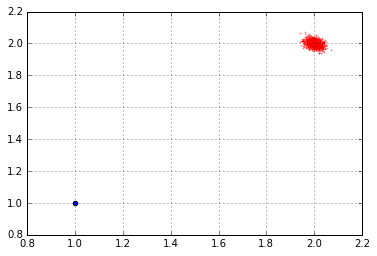

In [7]:
N = 1000
X0 = np.zeros((N, 3)) + np.array([1, 1, 0]).reshape((1, 3))
U = np.array([0, 0, 0, 1, 1, np.pi/3])

# 正常分布
X1 = sample_motion_model_odometry(U, X0, [0.0001, 0.0001, 0.0001, 0.0001])

plt.scatter(1, 1)
plt.scatter(X1[:,0], X1[:,1], c='r', lw=0, alpha=0.5, s=3)
plt.grid()

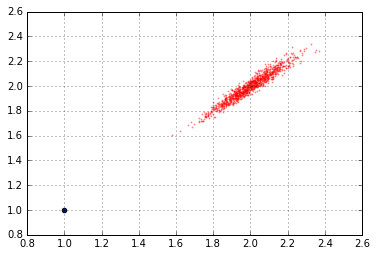

In [8]:
N = 1000
X0 = np.zeros((N, 3)) + np.array([1, 1, 0]).reshape((1, 3))
U = np.array([0, 0, 0, 1, 1, np.pi/3])

# 平移误差较大
X1 = sample_motion_model_odometry(U, X0, [0.0001, 0.0001, 0.01, 0.01])

plt.scatter(1, 1)
plt.scatter(X1[:,0], X1[:,1], c='r', lw=0, alpha=0.5, s=3)
plt.grid()

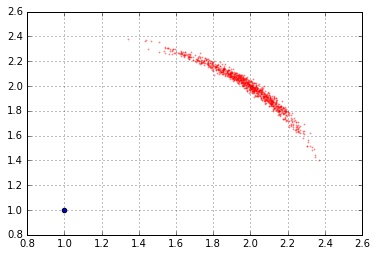

In [9]:
N = 1000
X0 = np.zeros((N, 3)) + np.array([1, 1, 0]).reshape((1, 3))
U = np.array([0, 0, 0, 1, 1, np.pi/3])

# 旋转角度误差较大
X1 = sample_motion_model_odometry(U, X0, [0.01, 0.01, 0.0001, 0.0001])

plt.scatter(1, 1)
plt.scatter(X1[:,0], X1[:,1], c='r', lw=0, alpha=0.5, s=3)
plt.grid()